In [7]:
import pandas as pd
import pickle 
import re
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud

from scipy.spatial.distance import cosine
from gensim.models import FastText

import sys
sys.path.append('../code')

from preprocessing import GlowpickPreprocessing, Filtering, l2norm
from loaddata import load

import warnings
warnings.filterwarnings('ignore')

# Configuration

In [8]:
reviewpath = '../dataset/glowpick_reviews.csv' # review data path to load
productpath = '../dataset/glowpick_products.csv' # product data path to load
infopath = '../dataset/glowpick_info.csv' # product information path to load

savedir = '../saved_file'

modelname = 'multi_pre_embed'

data, products, infos = load(reviewpath, productpath, infopath)

GP = GlowpickPreprocessing()

[LOAD           ] Load data...(data.shape: ,(461659, 7))(products.shape: ,(12698, 9))(infos.shape: ,(12243, 3))
[LOAD           ] filtering data...(filtering data shape: (10390, 4)


In [9]:
wc = WordCloud(font_path='/usr/share/fonts/truetype/NanumGothic.ttf', 
               background_color="white", 
               max_words=20000, 
               min_word_length=2,
               max_font_size=300)

# Recommendation

In [32]:
def evaluation(search,
               modelname, 
               pre_embedname,
               savedir='../saved_file', 
               reviewpath='../dataset/glowpick_reviews.csv', 
               productpath='../dataset/glowpick_products.csv',
               infopath='../dataset/glowpick_info.csv'):
    
    print('[{0:15s}] Evaluation'.format('STATE'))
    # configuration
    GP = GlowpickPreprocessing()
    # - feature selection
    show_features = ['category','brand','nb_reviews','vol_price','product','product_url']
    # - load embed model
    model = FastText.load(f'{savedir}/{modelname}.bin')
    # - filtering class
    filtering = Filtering(show_features)

    # 1. load data
    data, products, info = load(reviewpath, productpath, infopath)

    # 2. preprocessing new sentence
    # test_text = GP.fit([args.search], args.wordpath, args.pospath)
    test_text = list(map(GP.stopword, [search]))
    test_text = GP.spacefix(test_text)
    test_text = GP.wordfix(test_text,'../saved_file/replace_word.json')
    test_text = GP.kkma.nouns(' '.join(test_text[0]))
    print('[{0:15s}] result : {1:}'.format('PREPROCESSING',test_text))
    test_sent_vec = GP.sent2vec(test_text, model)
    test_sent_vec = l2norm(test_sent_vec)

    # 3. calculration similarity : cosine distance
    sent_vec = pickle.load(open(f'{savedir}/{pre_embedname}.pickle','rb'))
    dist_arr = np.zeros((sent_vec.shape[0]))
    for i, sent in enumerate(sent_vec):
        dist = cosine(sent, test_sent_vec[0])
        dist_arr[i] = dist
    data['dist'] = dist_arr
    data = pd.merge(data, products, on='product_url', how='left')

    # 4. featering
    data = filtering.fit(data, test_text)

    return data

# Test

In [33]:
search = '남자친구 선물로 괜찮은 스킨이나 로션'

In [34]:
test = evaluation(search=search,
                  modelname='new_model_word_pos',
                  pre_embedname='new_pre_embed_word_pos')

[STATE          ] Evaluation
[LOAD           ] Load data...(data.shape: ,(461659, 7))(products.shape: ,(12698, 9))(infos.shape: ,(12243, 3))
[LOAD           ] filtering data...(filtering data shape: (10390, 4)
Loading JIT Compiled ChatSpace Model
[PREPROCESSING  ] result : ['남친', '선물', '스킨', '로션']
[FILTERING      ] number of reviews (data shape: (5834, 13))
[FILTERING      ] rating (data shape: (4320, 13))
[FILTERING      ] sorting and drop duplicates (data shape: (1722, 6))

[STATE          ] Evaluation
[LOAD           ] Load data...(data.shape: ,(461659, 7))(products.shape: ,(12698, 9))(infos.shape: ,(12243, 3))
[LOAD           ] filtering data...(filtering data shape: (10390, 4)
Loading JIT Compiled ChatSpace Model
[PREPROCESSING  ] result : ['남친', '선물', '스킨', '로션']
[FILTERING      ] number of reviews (data shape: (5834, 13))
[FILTERING      ] rating (data shape: (4320, 13))
[FILTERING      ] sorting and drop duplicates (data shape: (1722, 6))


In [36]:
test.head()

,category,brand,nb_reviews,vol_price,product,product_url
4541,로션,우르오스 (ULOS),250,"200ml29,700원",스킨밀크,/product/3691
3111,스킨,이니스프리 (innisfree),82,"180ml19,000원",포레스트 포맨 모이스처 스킨,/product/7212
3536,스킨,이니스프리 (innisfree),61,"100ml25,000원",포레스트 포맨 프레시 올인원 에센스,/product/7198
3537,로션,이니스프리 (innisfree),61,"100ml25,000원",포레스트 포맨 프레시 올인원 에센스,/product/7198
3538,에센스,이니스프리 (innisfree),61,"100ml25,000원",포레스트 포맨 프레시 올인원 에센스,/product/7198


# 리뷰 확인해보기

In [37]:
test_url = test.head().product_url.tolist()
test_words = list(map(GP.kkma.nouns, data[data.product_url.isin(test_url)].content.tolist()))

test_text = []
for words2 in test_words:
    test_text.extend(words2)
test_text = ' '.join(test_text)
test_text = re.sub('[\d,^ㄱ-ㅎㅏ-ㅣ]', '', test_text)

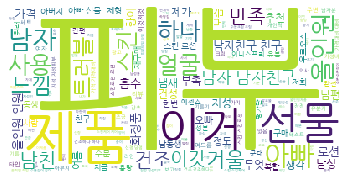

In [39]:
wc2 = wc.generate(test_text)
plt.imshow(wc2)
plt.axis('off')
plt.show()